IMPORT PACKAGES


In [38]:
import copy
import glob
import math
from collections import Counter
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import io
from skimage.feature import local_binary_pattern
from skimage.measure import regionprops
from skimage.segmentation import mark_boundaries, slic
from skimage.util import img_as_float



DEFINE SOME VARIABLES

In [84]:
NSP  = 250
n_intensidades = 256
MODO = 2
# 1 for SUPERPIXELS, 2 for BLOCKS
SPB = 1
raios = [3]
imagens = []
diretorio = "cbirImages/"
limiares = [0.100,0.200]

DEFINE THE FUNCTIONS

In [79]:
#if plota = 1 then show the image 
def geraSuperPixels(imagem,numeroDeSuperPixels,plota):
    if(len(imagem.shape) == 3):
        #color images
        segmentos = slic(imagem, n_segments = numeroDeSuperPixels, sigma = 5)
    else:
        # grayscale images
        segmentos = slic(imagem, n_segments = numeroDeSuperPixels, compactness=0.1, sigma = 5)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
  
    if(plota == 1):
        fig = plt.figure("SuperPixels")
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(mark_boundaries(imagem, segmentos))
        plt.axis("off")
        plt.show()

    return segmentos


def geraBlocos(imagem,numeroDeBlocos):
    if(len(imagem.shape) == 3):
        gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    else:
        gray = np.zeros(imagem.shape)
    windowsize_r = 8
    windowsize_c = 8
    contador=0
    for r in range(0,gray.shape[0] - windowsize_r, windowsize_r):
        for c in range(0,gray.shape[0] - windowsize_c, windowsize_c):
            gray[r:r+windowsize_r,c:c+windowsize_c] = contador
            contador+=1
    
    return gray 
##### FIRST ORDER STASTICS OF HISTOGRAM ####

# GENERATE THE HISTOGRAM OF COMPLEX NETWORKS #

def calculaHistogramaDoGrau(grafo,maxDegree):
    histograma = np.zeros(maxDegree)
    for vertice in grafo:
        grau = np.size(grafo[vertice][0])
        histograma[grau]+=1
    
    return histograma

# GENERATE THE HISTOGRAM OF INTENSITY LEVEL'S OR TEXTURE VALUES (LBP) # 

def geraHistogramaIntensidades(imagem,posistions):
    histograma = np.zeros(n_intensidades).astype(int)
    intensidades = imagem[posistions]
    for i in np.arange(n_intensidades):
        pixel_value_i = np.where(intensidades == i)
        histograma[i] = pixel_value_i[0].shape[0]
    return histograma

# PROBABILITY OF DEGREE I IN HISTOGRAM#
def calculaDensProbab(histograma,maxDegree):
    densProbab = np.zeros(maxDegree)
    densProbab =   histograma / (np.sum(histograma))
    return densProbab


# MEAN OF HISTOGRAM
def calculaMediaHistograma(densProbab,maxDegree):
    media = 0
    indices = np.arange(start=0, stop=maxDegree, step=1)
    prob = np.copy(densProbab)
    media = np.sum((indices * prob))
    return media

# ENTROPY
def calculaEntropia(densProbab,maxDegree):
   
    posistions = np.where(densProbab > 0)
    prob = np.copy(densProbab[posistions])
    logProb = np.log2(prob) 
    entropia = np.sum(prob*logProb)
    entropia = entropia*-1

    return(entropia)

#### END FIRST ORDER STATISTICS HISTOGRAM ####


#### BEGIN GENERATE VISUAL WORD FOR A SUPERPIXEL ####


#METHOD USING FIRST ORDER STATISTICS FROM THE HISTOGRAM OF INTENSITIES OR TEXTURE (LBP) 
def calculaAssEst(imagem,posistions):
    histograma = geraHistogramaIntensidades(imagem,posistions)
    representacao  = []
    dens = calculaDensProbab(histograma,n_intensidades)
    media = calculaMediaHistograma(dens,n_intensidades)
    entropia = calculaEntropia(dens,n_intensidades)
    representacao.append(int(media))
    representacao.append(round(entropia, 1))
    return representacao

def geraPalavraVisualEstatisticaHist(superPixel,segmentos,imagem):
    mask = np.zeros(imagem.shape[:2], dtype = "uint8")
    mask[segmentos == superPixel] = 255
    positions =  np.where(mask==255)
    palavraVisual = calculaAssEst(imagem,positions)
 
    return palavraVisual

#METHOD USING FIRST ORDER STATISTICS FROM THE HISTOGRAM OF DEGRESS (COMPLEX NETWORK)
def geraPalavraVisualRedeComplexa2(superPixel,segmentos,imagem):
    mask = np.zeros(imagem.shape[:2], dtype = "uint8")
    mask[segmentos == superPixel] = 255
    #POSITIONS FO THE BLOCK IN THE IMAGE
    positions =  np.where(mask==255)
    grafo = {}
    representacao = []

    for raio in raios:

        grafo,maxDegree = criaGrafoVizinhanca(positions,imagem,raio)
        if grafo == {}:
            break
        for limiar in limiares:
            grafoPodado = copy.deepcopy(grafo)
            for vertice in grafoPodado:
                array = np.array(grafoPodado[vertice][1])
                positions = np.where(array > limiar)
                grafoPodado[vertice][1] = np.delete(grafoPodado[vertice][1], positions) 
                grafoPodado[vertice][0] = np.delete(grafoPodado[vertice][0], positions) 
                    
            histograma = calculaHistogramaDoGrau(grafoPodado,maxDegree)
            distProbabilidade = calculaDensProbab(histograma,maxDegree)
            media = calculaMediaHistograma(distProbabilidade,maxDegree)
            entropia = calculaEntropia(distProbabilidade,maxDegree)
            representacao.append(int(media))
            representacao.append(int(entropia))
    return representacao

#### END GENERATE VISUAL WORD FOR A SUPERPIXEL ####


#### GENERATE COMPLEX NETWORK #### 

#versao final
def criaGrafoVizinhanca(positions,imagem,raio):
    grafo = {}
    numPixeisSp = positions[0].size
    centro = [sum(positions[0]) // numPixeisSp, sum(positions[1] // numPixeisSp)]
    limites = imagem.shape
    #FORCE THE CENTER TO BE IN A VALID POSITION
    if(centro[0] <= raio):
        centro[0] = centro[0] + raio
    if(centro[1] <= raio):
        centro[1] = centro[1] + raio
    
    if(abs(centro[0] - limites[0]) <= raio):
        centro[0] = centro[0] - raio
    if(abs(centro[1] - limites[1]) <= raio):
        centro[1] = centro[1] - raio
    vizinhos = imagem[centro[0]-raio:centro[0]+raio+1, centro[1]-raio:centro[1]+raio+1]

    maxDegree = 0

    if( vizinhos.shape[0] * vizinhos.shape[1] > 0):
        vPositions = np.where(vizinhos >= 0)

        L = np.amax(vizinhos)
        if L == 0:
            L = 1
        numPixeisVizinhanca = vizinhos.shape[0] * vizinhos.shape[1]
       
        for j in range(0,numPixeisVizinhanca):
            #CALCULATE THE DISTANCE OF THE ATUAL PIXEL AND THE OTHERS
            distanciaX = (vPositions[0][j] - vPositions[0][:])
            distanciaX = distanciaX * distanciaX
            distanciaY = (vPositions[1][j] - vPositions[1][:])
            distanciaY = distanciaY * distanciaY
            somaXY = distanciaX + distanciaY
            distanciaEuclidiana = np.sqrt(somaXY)
 
            maxL = np.max
            difNiveisDeIntensidade = abs(vizinhos[vPositions[0][j]][vPositions[1][j]] - vizinhos[vPositions])
            difNiveisDeIntensidade = difNiveisDeIntensidade / L
            difNiveisDeIntensidade = (raio*raio) * difNiveisDeIntensidade
            
            pesoAresta = distanciaX + distanciaY + difNiveisDeIntensidade
            pesoAresta = pesoAresta/ ((raio * raio) * (raio * raio) )

            adjacentes = np.where( distanciaEuclidiana <= raio )
            maxDegree = max(maxDegree, np.size(adjacentes))
            grafo[j] = [[adjacentes],[pesoAresta[adjacentes]]]
    if(grafo == {}):
        print("ERRO AO MONTAR GRAFO")
    return grafo, maxDegree+1
#### END GENERATE COMPLEX NETWORK 


#### BEGIN GENERATE THE SIGNATURE (FEATURE VECTOR) THAT WILL REPRESENT THE IMAGE ####

def geraConjuntoDePalavrasVisuais(imagem,numeroDeSuperPixels):

    if(SPB == 1):
        segmentos = geraSuperPixels(imagem,numeroDeSuperPixels,0)
    elif(SPB == 2):
        segmentos = geraBlocos(imagem,numeroDeSuperPixels)

    conjuntoDePalavrasVisuais = []
    
    if (MODO == 1):
        
        imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
        imagem = local_binary_pattern(imagem, 8, 1, method = 'ror').astype(int)
        smin=0; smax=255
        a = np.amin(imagem)
        b = np.amax(imagem)
        imagem = (( imagem - a ) * (smax )) / ( b -a ) 
        
        for superPixel in np.unique(segmentos):
            palavraVisual = geraPalavraVisualRedeComplexa2(superPixel,segmentos,imagem)
            conjuntoDePalavrasVisuais.append(palavraVisual)

    if( MODO == 2):
        imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
        for superPixel in np.unique(segmentos):
            palavraVisual = geraPalavraVisualEstatisticaHist(superPixel,segmentos,imagem)
            conjuntoDePalavrasVisuais.append(palavraVisual)
    return conjuntoDePalavrasVisuais

def estaDentro(elemento,lista):
    for x in lista:
        if (elemento == x):
            return True
    return False

def unicosLento(lista):
    unicos = []
    for x in lista:
        if(not estaDentro(x,unicos)):
            unicos.append(x)
    return unicos

def contaOcorrencias(x,lista):
    contador = 0
    for item in lista:
        if(x == item):
            contador+=1
    return contador

def calculaDistancia(lista1,lista2):
    index = 0
    dif = 0
    while(index < len(lista1)):
        dif+= abs(lista1[index] - lista2[index])
        index+=1
    return dif

def geraRepresentacaoImagens(imagens):
    #READ THE QUERY IMAGE
    filename = IMAGEMDEBUSCA
    #print(filename)
    imagemDeBusca = cv2.imread(diretorio+filename)
    #print(imagemDeBusca)
    vocabulario = []
    #generate the visual word for the query image
    conjuntoDePalavrasVisuaisImgBusca = geraConjuntoDePalavrasVisuais(imagemDeBusca,NSP)
    

    #generate the visual words for the images of the database
    conjuntoDePalavrasVisuaisImgsBaseDeDados = []
    for img in imagens:
        conjunto = geraConjuntoDePalavrasVisuais(img[0],NSP)
        conjuntoDePalavrasVisuaisImgsBaseDeDados.append([conjunto,img[1]])
        vocabulario+=conjunto

    vocabulario+=(conjuntoDePalavrasVisuaisImgBusca)
    vocabulario = unicosLento(vocabulario)

    # generate the signature for the query image
    representacaoImagemBusca = []
    for item in vocabulario:
        contador = contaOcorrencias(item,conjuntoDePalavrasVisuaisImgBusca)
        representacaoImagemBusca.append(contador)

    representacaoImagensDaBase = []
    representacaoImagensDaBase.append([representacaoImagemBusca,filename])
    # generate the signature for the images of the database
    for conjuntoDePalavras in conjuntoDePalavrasVisuaisImgsBaseDeDados:
        representacao = []
        
        for item in vocabulario:
            contador = contaOcorrencias(item,conjuntoDePalavras[0])
            representacao.append(contador)

        representacaoImagensDaBase.append([representacao,conjuntoDePalavras[1]])

    return representacaoImagensDaBase

def leImagens():
    images = []
    for filename in glob.glob( diretorio+"*.jpg"): 
        imagem = cv2.imread(filename)
        images.append([imagem,filename[10:]])
    #print(images)
    return images 

def calculaDistanciaEntreImagens(representacoes):
    imgConsulta = representacoes[0]
    distancias = []
    for i in range(1,len(representacoes)):
        distancia = calculaDistancia(imgConsulta[0],representacoes[i][0])
        distancias.append([distancia,representacoes[i][1]])
    return distancias

def cbir():
    imagens=leImagens()
    #QUERY IMAGE IN POSITION zero
    representacaoTodasImagens = geraRepresentacaoImagens(imagens)
    #CALCULATE THE DISTANCE BETWEEN THE QUERY IMAGE AND THE OTHER IMAGES
    distancias = calculaDistanciaEntreImagens(representacaoTodasImagens)
    distancias.sort(key = lambda x:x[0])
    #SHOW THE DISTANCE TO ALL THE IMAGES 
    print("RANK THE MOST SIMILAR IMAGES:")
    for i in range(22):
        print(i+1,distancias[i][1])
    contador = 1
    plt.figure(figsize=(10,10))
    for item in distancias:
        nomeImagem = diretorio+item[1]
        imagem = cv2.imread(nomeImagem)
        #print(imagem)
        imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
        plt.subplot(3,3,contador)
        plt.imshow(imagem)
        if(contador == 1):
            plt.title("Imagem de Consulta")
        else:
            plt.title("Resultado "+str(contador-1))
        plt.axis('off')
        contador+=1
        if(contador > 9 ):
            break
    plt.show()

#### END GENERATE THE SIGNATURE (FEATURE VECTOR) THAT WILL REPRESENT THE IMAGE ####



DIVIDE IMAGE USING SUPERPIXEIS AND DESCRIBE BLOCKS USING MEAN AND ENTROPY OF HISTOGRAM


RANK THE MOST SIMILAR IMAGES:
1 /janela_01.jpg
2 /janela_13.jpg
3 /janela_06.jpg
4 /janela_12.jpg
5 /janela_09.jpg
6 /janela_05.jpg
7 /janela_15.jpg
8 /janela_22.jpg
9 /janela_08.jpg
10 /janela_02.jpg
11 /janela_14.jpg
12 /janela_03.jpg
13 /janela_11.jpg
14 /janela_10.jpg
15 /janela_19.jpg
16 /janela_17.jpg
17 /janela_04.jpg
18 /janela_18.jpg
19 /janela_07.jpg
20 /urso_19.jpg
21 /janela_20.jpg
22 /janela_21.jpg


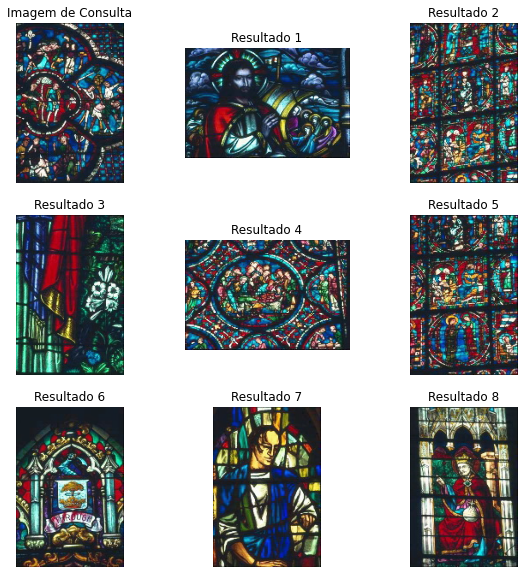

In [85]:
#run the code
#CHOOSE 1 FOR DIVIDE THE IMAGE IN BLOCKS USING SUPER PIXEIS 
#CHOOSE 2 FOR DIVIDE THE IMAGE IN BLOCKS USING 8x8 BLOCKS
SPB = 1
#CHOOSE 1 FOR GENERATE THE VISUAL WORD USING COMPLEX NETWORKS
#CHOOSE 2 FOR GENERATE THE VISUAL WORD USING FIRST ORDER STATISTICS
MODO = 2

IMAGEMDEBUSCA = "janela_01.jpg"

cbir()



DIVIDE IMAGE USING SUPERPIXEIS AND DESCRIBE BLOCKS USING COMPLEX NETWORKS

RANK THE MOST SIMILAR IMAGES:
1 /janela_01.jpg
2 /janela_02.jpg
3 /janela_06.jpg
4 /janela_09.jpg
5 /janela_05.jpg
6 /janela_11.jpg
7 /janela_03.jpg
8 /janela_08.jpg
9 /janela_15.jpg
10 /janela_13.jpg
11 /janela_04.jpg
12 /janela_22.jpg
13 /janela_17.jpg
14 /urso_03.jpg
15 /janela_19.jpg
16 /janela_14.jpg
17 /urso_05.jpg
18 /janela_21.jpg
19 /urso_17.jpg
20 /urso_12.jpg
21 /janela_10.jpg
22 /urso_06.jpg


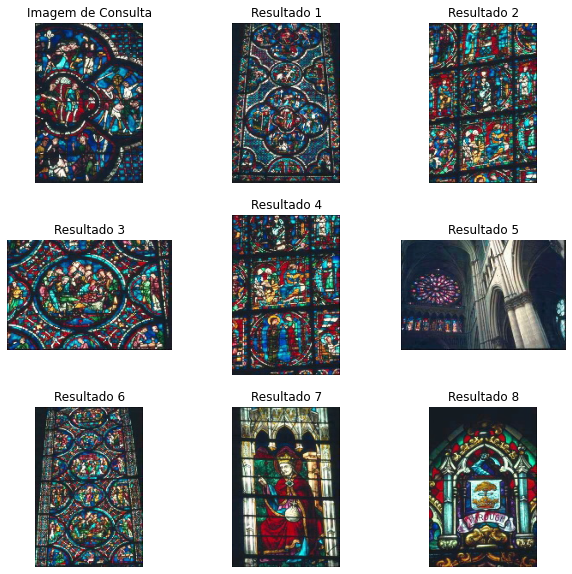

In [81]:
#run the code
#CHOOSE 1 FOR DIVIDE THE IMAGE IN BLOCKS USING SUPER PIXEIS 
#CHOOSE 2 FOR DIVIDE THE IMAGE IN BLOCKS USING 8x8 BLOCKS
SPB = 1
#CHOOSE 1 FOR GENERATE THE VISUAL WORD USING COMPLEX NETWORKS
#CHOOSE 2 FOR GENERATE THE VISUAL WORD USING FIRST ORDER STATISTICS
MODO = 1

IMAGEMDEBUSCA = "janela_01.jpg"

cbir()



DIVIDE IMAGE USING 8x8 BLOCKS AND DESCRIBE BLOCKS USING MEAN AND ENTROPY OF HISTOGRAM

RANK THE MOST SIMILAR IMAGES:
1 /janela_01.jpg
2 /janela_02.jpg
3 /janela_06.jpg
4 /janela_10.jpg
5 /janela_12.jpg
6 /janela_05.jpg
7 /janela_22.jpg
8 /janela_03.jpg
9 /janela_14.jpg
10 /janela_17.jpg
11 /janela_15.jpg
12 /janela_08.jpg
13 /janela_19.jpg
14 /janela_16.jpg
15 /janela_18.jpg
16 /janela_20.jpg
17 /janela_07.jpg
18 /urso_01.jpg
19 /urso_13.jpg
20 /janela_21.jpg
21 /urso_14.jpg
22 /urso_22.jpg


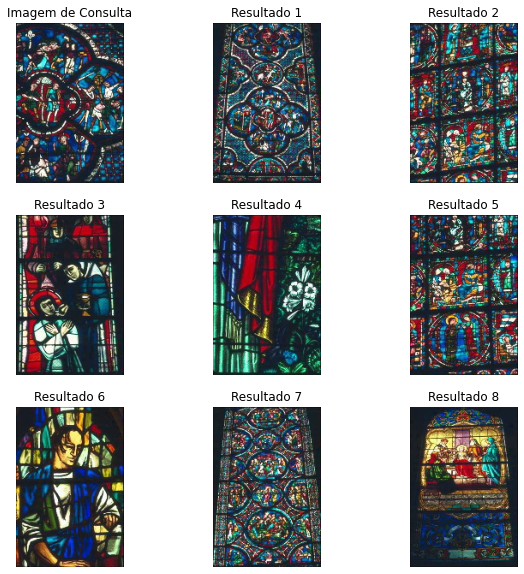

In [82]:
#run the code
#CHOOSE 1 FOR DIVIDE THE IMAGE IN BLOCKS USING SUPER PIXEIS 
#CHOOSE 2 FOR DIVIDE THE IMAGE IN BLOCKS USING 8x8 BLOCKS
SPB = 2
#CHOOSE 1 FOR GENERATE THE VISUAL WORD USING COMPLEX NETWORKS
#CHOOSE 2 FOR GENERATE THE VISUAL WORD USING FIRST ORDER STATISTICS
MODO = 2

IMAGEMDEBUSCA = "janela_01.jpg"

cbir()



DIVIDE IMAGE USING 8x8 BLOCKS AND DESCRIBE BLOCKS USING COMPLEX NETWORKS

RANK THE MOST SIMILAR IMAGES:
1 /janela_01.jpg
2 /janela_05.jpg
3 /janela_06.jpg
4 /janela_15.jpg
5 /janela_19.jpg
6 /janela_03.jpg
7 /janela_02.jpg
8 /janela_21.jpg
9 /janela_13.jpg
10 /janela_22.jpg
11 /urso_17.jpg
12 /urso_07.jpg
13 /urso_20.jpg
14 /janela_09.jpg
15 /janela_11.jpg
16 /urso_11.jpg
17 /urso_03.jpg
18 /janela_17.jpg
19 /urso_16.jpg
20 /urso_09.jpg
21 /urso_12.jpg
22 /urso_06.jpg


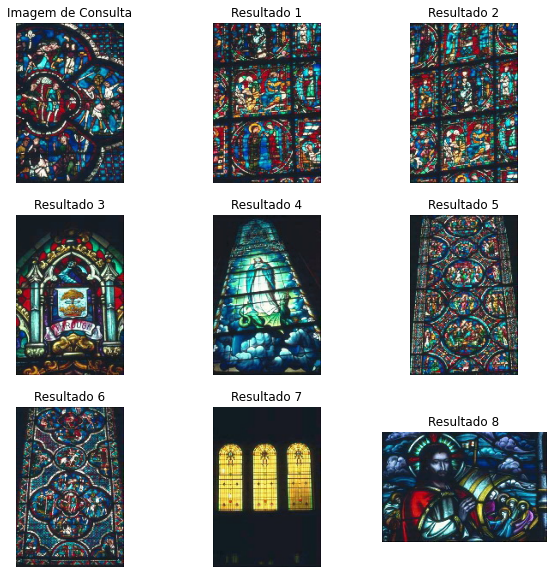

In [83]:
#run the code
#CHOOSE 1 FOR DIVIDE THE IMAGE IN BLOCKS USING SUPER PIXEIS 
#CHOOSE 2 FOR DIVIDE THE IMAGE IN BLOCKS USING 8x8 BLOCKS
SPB = 2
#CHOOSE 1 FOR GENERATE THE VISUAL WORD USING COMPLEX NETWORKS
#CHOOSE 2 FOR GENERATE THE VISUAL WORD USING FIRST ORDER STATISTICS
MODO = 1

IMAGEMDEBUSCA = "janela_01.jpg"

cbir()

